# Sentiment Analysis of Food Reviews

In this notebook I will read in some reviews from GeniusKitchen.com and attempt to classify the reviews into negative and positive (and potenitally neutral) reviews.  I will employ a variety of models:
* Logistic Regression
* Decision Trees
* Random Forests
* Neural Networks
* Embedding

The text data is stored as a panadas dataframe and is cleaned with RegEx.

### A note on Classification 
This dataset is actually ordinal, such that it goes from negative to neutral to positive. However I am treating this problem as a categorical one using the **One-vs-Rest** method.
<br> The justification for this is that we only want to predict whether the review is good/bad or not. Therefore it is irrelevant whether it is of another class, we only want to know whether it is part of the observed class or not.


## Import Libraries and Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import statistics
mean = statistics.mean
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import DataFunctions as dfs



## Read in the data
Here the data is read into 3 separate dataframes based on the review type.
The data has been previously cleaned for null values and ratings.


In [2]:
# Read in data
df_neutral = pd.read_csv("../Neutral_Reviews.csv")
df_negative = pd.read_csv("../Negative_Reviews.csv")
df_positive = pd.read_csv("../Positive_Reviews.csv")

print(f"There are: \n{len(df_neutral)} neutral reviews \n{len(df_negative)} negative reviews \n{len(df_positive)} positive reviews")

There are: 
40852 neutral reviews 
26937 negative reviews 
1003562 positive reviews


## Sampling
We have a fairly imbalanced dataset so to fix this we can randomly sample 26,000 reviews from each class - which is still plenty of data.

In [3]:
# As few negative reviews I shall sample 26,000 from each dataframe before resetting the index and dropping irrelevant columns.
n = 26000

df_negative = df_negative.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])
df_neutral = df_neutral.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])
df_positive = df_positive.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])


### Assigning Labels
We need to change the reviews from a star rating (1,2,3,4,5) to negative, neutral and positive labels (-1,0,1). Then we can concatenate them into one dataframe.

In [4]:
df_negative['class'] = "Negative"
df_neutral['class']  = "Neutral"
df_positive['class'] = "Positive"
df = df_negative.append(df_neutral).append(df_positive).reset_index().drop(columns=['index'])
df

,review,class
0,"My husband enjoyed this recipe, but my daughte...",Negative
1,This was a really good basic recipe. Traditio...,Negative
2,I&#039;ve been wanting to make my own cider fo...,Negative
3,"This was good, but I probably won't make it ag...",Negative
4,Made it last night for DS birthday. I must ha...,Negative
5,"Sorry, my family didn't like it. They said th...",Negative
6,Not really a beet fan...but am trying to give ...,Negative
7,"One bite, couldn&#039;t even swallow it. I ma...",Negative
8,"Salty! I didn't even use the salt on the top, ...",Negative
9,"These were okay, nothing to get excited about....",Negative


In [5]:
df['length'] = [len(i) for i in df['review']]
df.describe()

,length
count,78000.000000
mean,282.308423
std,209.593530
min,1.000000
25%,144.000000
50%,236.000000
75%,363.000000
max,4146.000000


### Visualise Data Stats
This can be used to determine the maximum and minimum review lengths to check there are no empty reviews and that they are all valid.

In [6]:
# Find lengths (i == review)
negative_lengths = [len(i) for i in df_negative.review]
neutral_lengths  = [len(i) for i in df_neutral.review]
positive_lengths = [len(i) for i in df_positive.review]


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


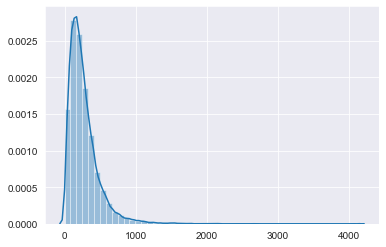

In [7]:
sns.distplot(negative_lengths);


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


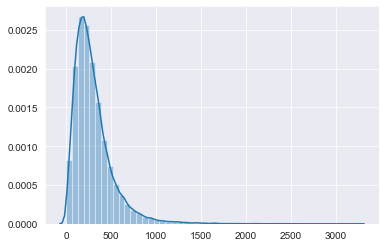

In [8]:
sns.distplot(neutral_lengths);


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


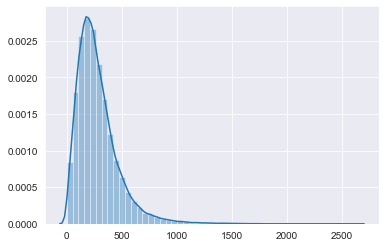

In [9]:
sns.distplot(positive_lengths); 

It appears there is a fairly normal distribution if outliers are ignored. 

In [10]:
# Look at average lengths
print(mean(negative_lengths), mean(neutral_lengths), mean(positive_lengths))

268.15384615384613 300.39 278.38142307692306


The average lengths all seem to sit around the same value too

## Text Cleaning
Here I shall remove punctuation and symbols as well as making each word lowercase. This allows us to analyse the data later on.

In [11]:
# Run our cleaning functions - please see the DataFunctions.py file for the regex syntax used.
df = dfs.clean_text(df, ['review'])

# Sanity check
df.review[0]

'my husband enjoyed this recipe but my daughters and i didnt  i thought the rice was too mushy  it also was too much rice for us  it needed a bit more spice for me'

### Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

# Train = 80% ; Test = 20% 
X_train_df, X_test_df, y_train, y_test = train_test_split(df['review'],df['class'], test_size=0.2, random_state = 101)

y_train.value_counts() # Check for class imbalance 

Negative    20824
Neutral     20812
Positive    20764
Name: class, dtype: int64

## Create the Corpus
This is essentially all the words in our training dataset - bag of words approach. This part of code creates the corpus of key:value pairs consisting of a token (basically an ID) and a corresponding word. This corpus is then fit to the training and test set, producing a sparse matrix (mostly 0's). What this actually represent is each review as a vector of the words contained in it.
<br> To better demonstrate this: 
<br>example = "This is an example"
<br>corpus = "This is an example of words in a corpus" = [0,1,2,3,4,5,6,7,8]
<br>vector(example) = [1,1,1,1,0,0,0,0,0] . [0,1,2,3,4,5,6,7,8] (Review vector and corresponding corpus tokens)
<br>The above vector is given as it contains 1 of each of the first 4 words in the corpus, but none of the others.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the corpus of words contained within all of our documents - Bag of words
cv = CountVectorizer(binary=True)
cv.fit(X_train_df)

# Transform reviews into sparse matrix based on words contained in corpus
X_train = cv.transform(X_train_df)
X_test = cv.transform(X_test_df)

In [14]:
# All words in corpus.  Key:Value == Words:Token
# print((cv.vocabulary_))

In [15]:
# Sanity Check
(X_train.shape),(X_test.shape),set(y_train)

((62400, 39874), (15600, 39874), {'Negative', 'Neutral', 'Positive'})

## Creating our Models

Below this problem will solved as a multi-class problem. In th

### Decision Tree

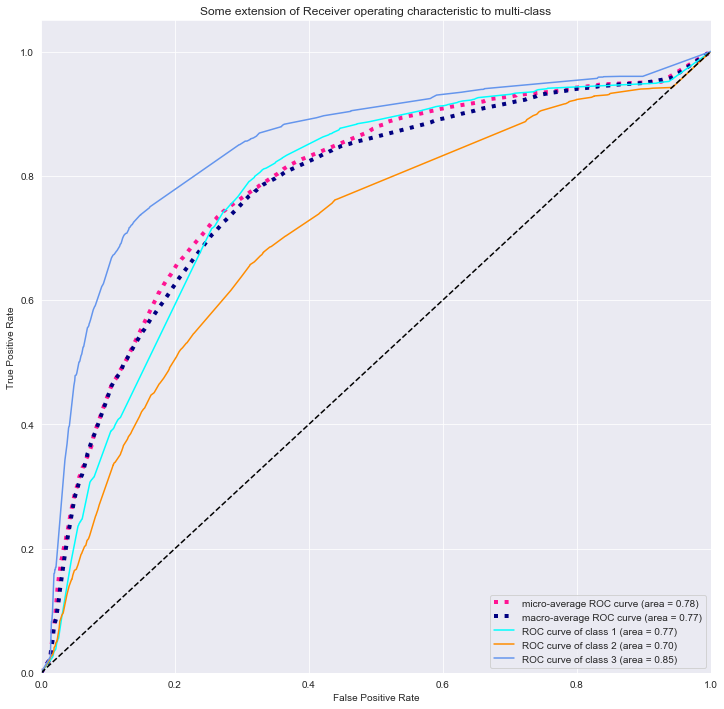

One-vs-Rest ROC AUC scores:
0.774619 (macro),
0.774838 (weighted by prevalence)
None
[[[7099 3325]
  [1040 4136]]

 [[7008 3404]
  [1708 3480]]

 [[8931 1433]
  [1437 3799]]]


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

list_of_classes = ['Negative','Neutral','Positive']
class_labels = [0,1,2]

clf = DecisionTreeClassifier(criterion='gini', max_depth=15, class_weight='balanced')
clf = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, clf, list_of_classes, class_labels)

### Random Forest

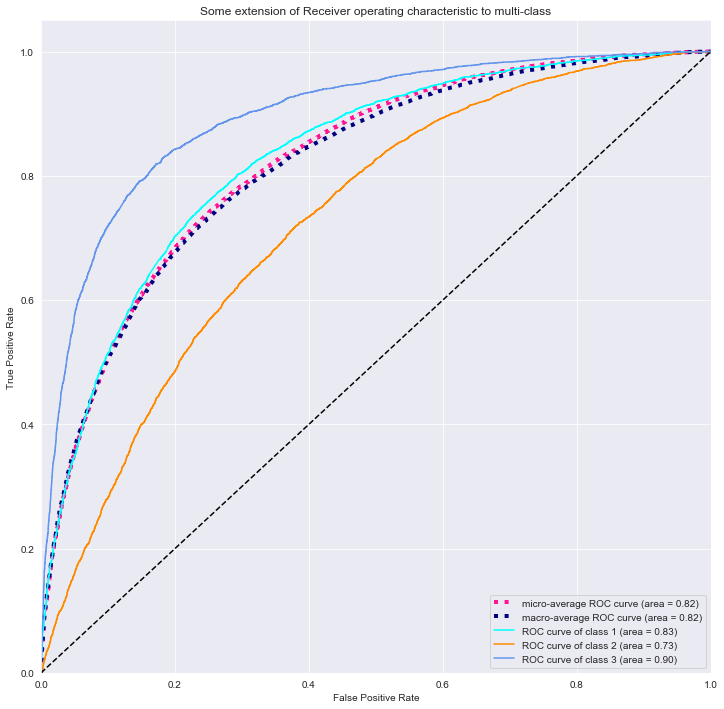

One-vs-Rest ROC AUC scores:
0.817998 (macro),
0.818228 (weighted by prevalence)
None
[[[10357    67]
  [ 4658   518]]

 [[10268   144]
  [ 4927   261]]

 [[10237   127]
  [ 3901  1335]]]


In [17]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, max_depth= 25)
# forest.fit(X_train, y_train)
# y_pred_train = forest.predict(X_train)
# y_pred_val = forest.predict(X_val)
forest = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, forest, list_of_classes, class_labels)

### Logistic Regression

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


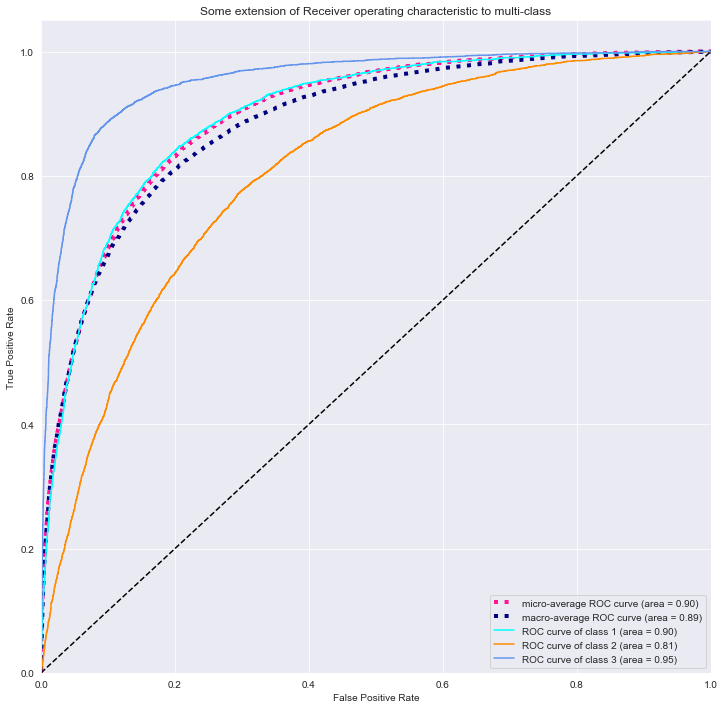

One-vs-Rest ROC AUC scores:
0.886322 (macro),
0.886521 (weighted by prevalence)
None
[[[9332 1092]
  [1517 3659]]

 [[9052 1360]
  [2519 2669]]

 [[9714  650]
  [ 932 4304]]]


In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.05)

lr = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, lr, list_of_classes, class_labels)

Logistic Regression provides the best model with the highest ROC AUC scores for classification. Looking carefully at the above plots it is possible to see the ability to classify positive or negative reviews is much easier than classifying neutral ones. This is likely because both positive and negative words appear in a neutral review.

## Inferring from the Model

In [19]:
word_coeff = zip(cv.get_feature_names(), lr.coef_[0])
word_to_coeff = {word: coeff for word, coeff in word_coeff}

most_accurate_positive_words=[]
for best_positive_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:10]:
    most_accurate_positive_words.append(best_positive_words)

print (f"The 10 words as best predictors for a positive review are:\n {most_accurate_positive_words}\n")
    

most_accurate_negative_words=[]    
for best_negative_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1],
    reverse=True)[:10]:
    most_accurate_negative_words.append(best_negative_words)

print (f"The 10 words as best predictors for a negative review are:\n {most_accurate_negative_words}\n")

The 10 words as best predictors for a positive review are:
 [('delicious', -1.2982505020983433), ('excellent', -1.2572571176297929), ('loved', -1.196020265073792), ('thanks', -1.1386661556925488), ('perfect', -1.019149233421855), ('thank', -0.9820219377175801), ('enjoyed', -0.9744175870863462), ('yummy', -0.9690008611745062), ('wonderful', -0.9624837481685535), ('fantastic', -0.9600769987734132)]

The 10 words as best predictors for a negative review are:
 [('terrible', 1.2520276551492393), ('waste', 1.2244625084110823), ('worst', 1.1790060553574375), ('horrible', 1.1534585959651418), ('awful', 1.1020261315765576), ('tasteless', 1.0806671507772942), ('inedible', 0.8966163926085468), ('sorry', 0.8878148584900716), ('gross', 0.8636617754699537), ('disappointing', 0.8108332452641813)]



In [20]:
sorted(word_to_coeff.items(), key=lambda x: x[1],reverse=True)

[('terrible', 1.2520276551492393),
 ('waste', 1.2244625084110823),
 ('worst', 1.1790060553574375),
 ('horrible', 1.1534585959651418),
 ('awful', 1.1020261315765576),
 ('tasteless', 1.0806671507772942),
 ('inedible', 0.8966163926085468),
 ('sorry', 0.8878148584900716),
 ('gross', 0.8636617754699537),
 ('disappointing', 0.8108332452641813),
 ('sounded', 0.7988073408725753),
 ('yuck', 0.7815543048820316),
 ('ruined', 0.7788675871423762),
 ('wasted', 0.7723565745219179),
 ('disgusting', 0.7655536849974386),
 ('disappointment', 0.7443778953492498),
 ('not', 0.732585863665286),
 ('flavorless', 0.7307577787907018),
 ('edible', 0.7244534507029496),
 ('smelled', 0.7002845045584365),
 ('throw', 0.7001493459812246),
 ('disaster', 0.675749640483537),
 ('bland', 0.6599097200991659),
 ('disappointed', 0.6571659904410144),
 ('mess', 0.6386812942409251),
 ('nothing', 0.6338146564084588),
 ('boring', 0.6248387485178407),
 ('nobody', 0.624495950893917),
 ('hated', 0.6200812253660629),
 ('wont', 0.585987

# Further Processing
As can be seen above, the model performs quite well. There are still ways to try and improve it though. One common technique is to remove stop-words - words such as it/he/she/the/as which distort the frequency of all words in the corpus. It can also be seen that that the best words have repetition (thanks, thank) - this is where Stemming and Lemmatization come in and reduce these "duplicates" down to one word. There are also other factors that could be influencing our data such as phrasing - E.g. where one person has said "loved this recipe" someone else may have said "didn't love it" - a perfect use case for n-grams - a method which allows us to not only look at single words, but also of phrases consisting of n words.


## TF-IDF and n-grams
TF-IDF is Term Frequency - Inverse Document Frequency. This method essentially weights each word in the corpus by how many times it appears in all the documents to give it a measure of how 'important' the word is. n-grams provide a way to look at more than one word at a time. Below I choose n=2 so that we are looking at pairs of words in addition to singular words.
<br> I fit the new features to a Logisitc Regression model for comparison - as this was previously our best performing model

In [21]:
from sklearn.model_selection import train_test_split

# Train = 80% ; Test = 20% 
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['class'], test_size=0.2, random_state = 101)

y_train.value_counts() # Check for class imbalance 

Negative    20824
Neutral     20812
Positive    20764
Name: class, dtype: int64

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(binary=True,ngram_range=(1,2))
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


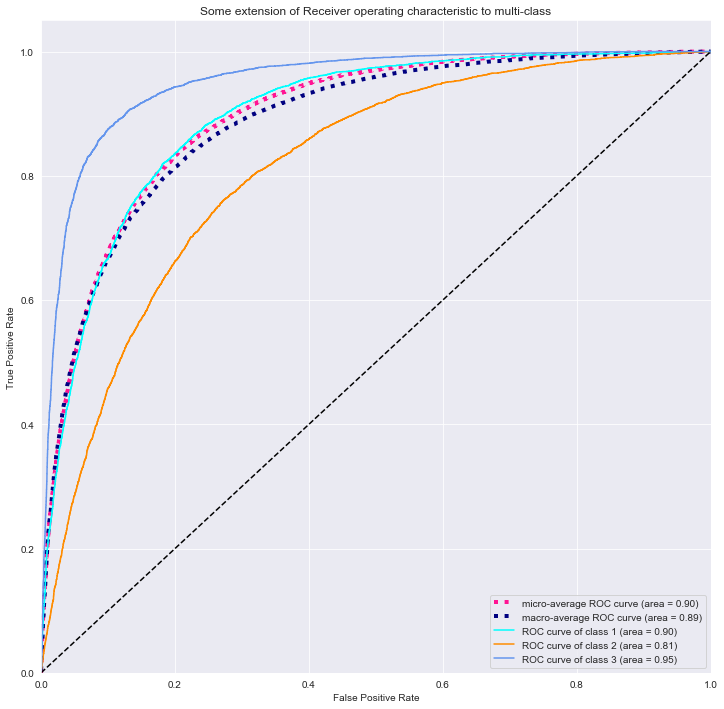

One-vs-Rest ROC AUC scores:
0.886683 (macro),
0.886872 (weighted by prevalence)
None
[[[10142   282]
  [ 3340  1836]]

 [[10087   325]
  [ 4172  1016]]

 [[10143   221]
  [ 2293  2943]]]


In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.05)

lr = dfs.multiclass_classifier(X_train_tfidf, X_test_tfidf, y_train, y_test, lr, list_of_classes, class_labels)

Interestingly this model has a similar AUC and is much better at classifying 'rest' than the actual class here but often fails to predict whether it is a positive or negative review. Therefore TF-IDF has actually decreased the model performance and will not be used in the final model.

## Stemming

In [24]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

reviews=[]
for review in df.review:
    review = ([ps.stem(j) for j in review.split()])
    reviews.append(' '.join(review))

df_stemmed = pd.DataFrame({'review':reviews,'class':df['class']})
df_stemmed.head()

,review,class
0,my husband enjoy thi recip but my daughter and...,Negative
1,thi wa a realli good basic recip tradit bi bim...,Negative
2,i&#039v been want to make my own cider for yea...,Negative
3,thi wa good but i probabl wont make it again i...,Negative
4,made it last night for ds birthday i must have...,Negative


In [25]:
from sklearn.model_selection import train_test_split

# Train = 80% ; Test = 20% 
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(df_stemmed['review'],df_stemmed['class'], test_size=0.2, random_state = 101)

y_train.value_counts() # Check for class imbalance 

Negative    20824
Neutral     20812
Positive    20764
Name: class, dtype: int64

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the corpus of words contained within all of our documents - Bag of words
cv = CountVectorizer(binary=True)
cv.fit(X_train_stemmed)

# Transform reviews into sparse matrix based on words contained in corpus
X_train_stemmed = cv.transform(X_train_stemmed)
X_test_stemmed = cv.transform(X_test_stemmed)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


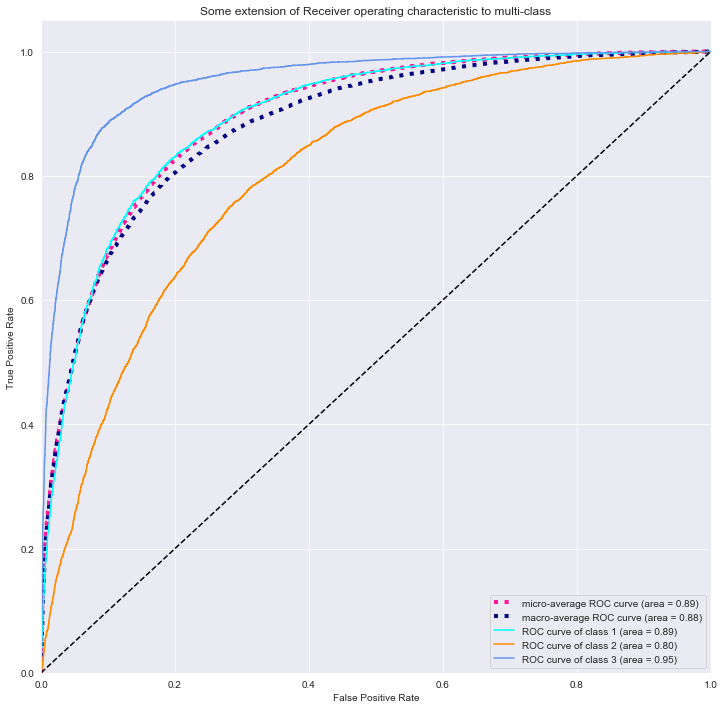

One-vs-Rest ROC AUC scores:
0.883316 (macro),
0.883520 (weighted by prevalence)
None
[[[9324 1100]
  [1572 3604]]

 [[9040 1372]
  [2577 2611]]

 [[9719  645]
  [ 933 4303]]]


In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.05)

lr = dfs.multiclass_classifier(X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed, lr, list_of_classes, class_labels)

Here, stemming produces almost the same result bar a 1% decrease for class 2 prediction. This is likely because the words present are used throughout all class types (ie. in negative and positive reviews). Therefore stemming them all to the same 'word'/stem has actually decreased the model performance and it is better off not using these word normalization techniques.

## Neural Network (In Progress)

In [89]:
# Make Binary
df_2 = df
df_2['class'] = list(map(lambda x: 0 if x!='Positive' else 1, df_2['class']))
df_2

,review,class,length
0,my husband enjoyed this recipe but my daughter...,0,168
1,this was a really good basic recipe tradition...,0,1150
2,i&#039ve been wanting to make my own cider for...,0,2120
3,this was good but i probably wont make it agai...,0,215
4,made it last night for ds birthday i must hav...,0,407
5,sorry my family didnt like it they said the c...,0,100
6,not really a beet fanbut am trying to give the...,0,623
7,one bite couldn&#039t even swallow it i made ...,0,166
8,salty i didnt even use the salt on the top but...,0,424
9,these were okay nothing to get excited about w...,0,168


In [90]:
from sklearn.model_selection import train_test_split

# Train = 80% ; Test = 20% 
X_train_df, X_test_df, y_train, y_test = train_test_split(df_2['review'], df_2['class'], test_size=0.2, random_state = 101)

y_train.value_counts()

0    41636
1    20764
Name: class, dtype: int64

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the corpus of words contained within all of our documents - Bag of words
cv = CountVectorizer(binary=True)
cv.fit(X_train_df)

# Transform reviews into sparse matrix based on words contained in corpus
X_train = cv.transform(X_train_df)
X_test = cv.transform(X_test_df)

In [92]:
import keras
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import label_binarize

# y_train, y_test = label_binarize(y_train, classes=['Negative', 'Neutral', 'Positive']), label_binarize(y_test, classes=['Negative', 'Neutral', 'Positive'])


In [93]:
val_size = int(len(y_test)/2)

y_val, y_test = y_test[:val_size], y_test[val_size:] 
X_val, X_test = X_test[:val_size], X_test[val_size:] 

In [120]:
from keras.models import Sequential
from keras import layers
from keras import regularizers

l1 = regularizers.l1(1*10**(-6)) # With a large number of features, l1 regularization becomes important to reduce overfitting

model = Sequential()

model.add(layers.Dense(64, input_dim = X_train.shape[1], activation='relu', activity_regularizer=l1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu', activity_regularizer=l1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu', activity_regularizer=l1))

model.add(layers.Dense(2, activation ='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                2552000   
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_71 (Dense)             (None, 2)                 130       
Total params: 2,560,450
Trainable params: 2,560,450
Non-trainable params: 0
_________________________________________________________________


## Note on Batch Sizes and Regularization
Performing gradient descent on batches, instead of the whole dataset, **reduces training** time and therefore is a useful method when optimizing hyperparameters (such as l1, l2, learning rate, number of units etc.)
<br> However, **batches introduce some regularization** as each batch contains noise. By using different batches for each iteration of gradient descent, the features observed (words in this case) and their corresponding weights will specific to that batch and so some features which are highly weighted in one batch may not be in the next. <br> As a result you may need to **reduce the size of regularization parameters l1 and l2** otherwise your neural network may not converge to the global minimum.

In [121]:
opt = Adam(lr=0.01)  # Combines momentum and RMS gradient descent to speed up training and get out of saddle points (where gradient is very close to 0)

batch_size = int(X_train.shape[0]/16) # 16 batches (may slightly faster training to split data as powers of 2)


model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', # One output value (either y=0 or y=1 for target, not array) - for multiclass use categorical_crossentropy
              metrics=['accuracy'])

hist = model.fit(x=X_train, y=y_train, 
                   batch_size=batch_size, 
                   validation_data=(X_val, y_val),
                   class_weight={0:1.0, 1:2.0},
                   epochs=20)

Train on 62400 samples, validate on 7800 samples
Epoch 1/20
62400/62400 [==============================] - 51s 815us/step - loss: 0.9280 - acc: 0.5975 - val_loss: 0.6946 - val_acc: 0.3388
Epoch 2/20
62400/62400 [==============================] - 43s 695us/step - loss: 0.9238 - acc: 0.5614 - val_loss: 0.6930 - val_acc: 0.6612
Epoch 3/20
62400/62400 [==============================] - 47s 748us/step - loss: 0.9239 - acc: 0.4583 - val_loss: 0.6902 - val_acc: 0.6612
Epoch 4/20
62400/62400 [==============================] - 46s 739us/step - loss: 0.9239 - acc: 0.4560 - val_loss: 0.6928 - val_acc: 0.6612
Epoch 5/20
62400/62400 [==============================] - 45s 724us/step - loss: 0.9239 - acc: 0.5607 - val_loss: 0.6941 - val_acc: 0.3388
Epoch 6/20
62400/62400 [==============================] - 47s 754us/step - loss: 0.9238 - acc: 0.6042 - val_loss: 0.6931 - val_acc: 0.6612
Epoch 7/20
62400/62400 [==============================] - 44s 708us/step - loss: 0.9238 - acc: 0.3742 - val_loss: 0.6

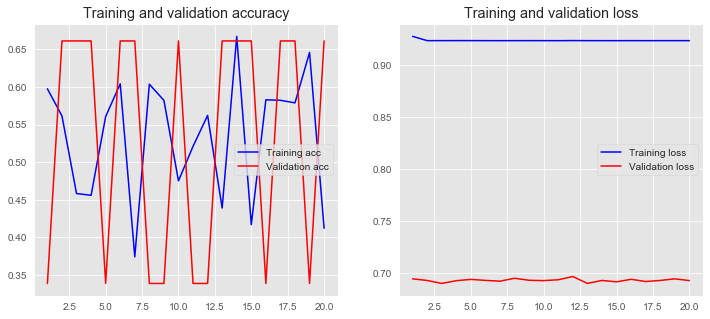

In [122]:
plot_history(hist)

In [123]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f} \nTraining Loss: {:.4f}".format(accuracy, loss))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f} \nTesting Loss:  {:.4f}".format(accuracy, loss))

Training Accuracy: 0.6672 
Training Loss: 0.6929
Testing Accuracy:  0.6676 
Testing Loss:  0.6929


# Word Embeddings
This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

## Note on Emebdding
After trying various models, embedding performs very poorly and doesn't seem to be succeseful at classification. I believe this is because the dataset contains reviews which are very short - a sentence or two or even shorter. This could mean our embedding cannot properly map the semantic meaning to geographical space as there is not a lot of structure to the sentences.

#### Things to try
There are some things to try to improve the model could be:
* Lemmatization - Reducing words to their root (generally preferred over stemming)
* Transfer Learning - Use a previously trained embedding model such as GloVe or Word2Vec on the dataset, allow it to be further trained on our dataset.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_df)

X_train_k = tokenizer.texts_to_sequences(X_train_df)
X_test_k = tokenizer.texts_to_sequences(X_train_df)

vocab_size = len(tokenizer.word_index) + 1  

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 10

X_val_k, X_test_k = X_test_k[:val_size], X_test_k[val_size:] 

X_train_k = pad_sequences(X_train_k, padding='post', maxlen=maxlen)
X_val_k = pad_sequences(X_val_k, padding='post', maxlen=maxlen)
X_test_k = pad_sequences(X_test_k, padding='post', maxlen=maxlen)



In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())  # Pefroms better than: model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(3, activation='sigmoid'))

model.summary()


In [ ]:
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
hist = model.fit(x=X_train_k, y=y_train, 
          validation_data=(X_val_k, y_val), epochs=15)


In [62]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(hist)

NameError: name 'hist' is not defined

In [ ]:
loss, accuracy = model.evaluate(X_train_k, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_k, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))